# T<sub>1</sub> Variations between Qubits

> 4/26/19

In this document, I'd like to measure T<sub>1</sub> for several different qubits and compare the results. This builds on the earlier notebook `Energy_Relaxation_Measurement.ipynb`, which in turn implements a measurement given in the IBM user guide. While my values for T<sub>1</sub> seem to be off by several orders of magnitude for a single qubit, I suspect that this is simply due to a rather messy conversion from CPU cycles to seconds. However, the relative difference between the T<sub>1</sub> measurements for any two qubits should be preserved, so I can still check my results against the IBM calibration values that way.

In [18]:
# import standard libraries
from collections import Counter  # useful for tallying results
import qiskit as q
import qiskit.tools.monitor as monitor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

q.IBMQ.load_accounts()

Since this circuit is so similar to that in the previously mentioned notebook, I won't bother documenting it very thoroughly here unless I get particularly good results that I'd like to showcase. That decision will probably come back to bite me at a later date.

In [63]:
qr = q.QuantumRegister(2, 'q')
cr = q.ClassicalRegister(2, 'c')

# preparation stage
prepare = q.QuantumCircuit(qr, cr)
prepare.x(qr)
prepare.barrier()

# measurement stage
measure = q.QuantumCircuit(qr, cr)
measure.barrier()
measure.measure(qr, cr)

# build idle stages
circuits = []
for n in range(50):
    idle = q.QuantumCircuit(qr, cr)
    for _ in range(45 * n):
        idle.iden(qr)
    circuits += [prepare + idle + measure]

And again, here is what an example circuit looks like, just for reference (where `id` represents $45n$ identity gates, $0 \le n \lt 50$):

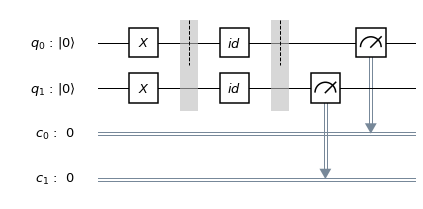

In [70]:
idle = q.QuantumCircuit(qr, cr)
idle.iden(qr)
(prepare + idle + measure).draw(output='mpl')

This time, we will extract the data for both qubits from each trial.

In [12]:
# analyze a trial and return the results as a tuple
def count_results(result, circuits, shots=1024):
    freq1 = []    # frequency of '1' state for each qubit
    freq2 = []
    stderr1 = []  # standard error for each qubit
    stderr2 = []
    
    for c in circuits:
        trial = Counter(result.get_counts(c))
        p1 = (trial['01'] + trial['11']) / shots
        p2 = (trial['10'] + trial['11']) / shots
        freq1 += [p1]
        freq2 += [p2]
        stderr1 += [np.sqrt(p1 * (1 - p1) / shots)]
        stderr2 += [np.sqrt(p2 * (1 - p2) / shots)]
    return freq1, freq2, stderr1, stderr2

Again, let's try it on the simulator:

Text(0, 0.5, 'p(1)')

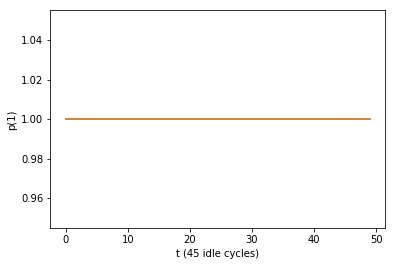

In [15]:
# run on simulator
simulator = q.BasicAer.get_backend('qasm_simulator')
job = q.execute(circuits, simulator, shots=1024)
p1, p2, s1, s2 = count_results(job.result(), circuits)

# plot simulation results
fig, ax = plt.subplots()
ax.errorbar(range(len(circuits)), p1, s1)
ax.errorbar(range(len(circuits)), p2, s2)
ax.set_xlabel('t (45 idle cycles)')
ax.set_ylabel('p(1)')

which are the flat lines that we expected. And now for the actual device:

In [66]:
# locate least busy IBM device backend
backends = q.IBMQ.backends(filters=lambda x:
                           x.configuration().n_qubits >= 2
                           and not
                           x.configuration().simulator)
best = q.providers.ibmq.least_busy(backends)

# run the trials on that backend
job = q.execute(circuits, backend=best, shots=1024,
                max_credits=10)
monitor.job_monitor(job)

# print job info for later retrieval if necessary
print('Job ID \'%s\'' % job.job_id())
print('Ran on backend \'%s\'' % best.name())
print('Completed %s' % job.creation_date())

/home/eric/anaconda3/envs/quantum/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqprovider.py:251: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cc345f1070405006f1f911a'
Ran on backend 'ibmqx2'
Completed 2019-04-26T17:54:57.404Z


Now we can retrieve the job and analyze the results:

Text(0, 0.5, 'p(1)')

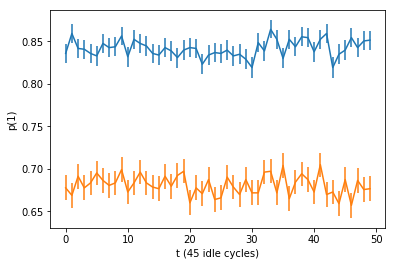

In [74]:
# retrieve job from job_id so that it's easier to re-run later
backend = q.IBMQ.get_backend('ibmqx2')
job = backend.retrieve_job('5cc345f1070405006f1f911a')

# plot experimental results
p1, p2, s1, s2 = count_results(job.result(), circuits)
fig, ax = plt.subplots()
ax.errorbar(range(len(circuits)), p1, s1)
ax.errorbar(range(len(circuits)), p2, s2)
ax.set_xlabel('t (45 idle cycles)')
ax.set_ylabel('p(1)')

Well, this is slightly puzzling: there doesn't seem to be any energy relaxation at all! $p(1)$ for each qubit seems to be staying relatively constant. This is slightly troubling; I haven't documented it fully, but some further investigation reveals that the presence of a second qubit somehow stabilized the state of both qubits. The funny thing is that I don't even have to measure the second qubit; its inclusion in the program is enough to destroy the energy relaxation that we're measuring. Here's an example: using the following circuit, we get a very nice T<sub>1</sub> measurement:

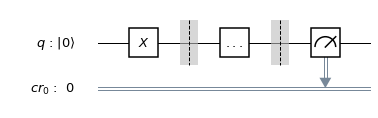

In [77]:
# replace 'id' with '...' for display points
style = {'displaytext': {'id': '...', 'u0': 'U_0', 'u1': 'U_1', 'u2': 'U_2', 'u3': 'U_3', 'x': 'X', 'y': 'Y', 'z': 'Z', 'h': 'H', 's': 'S', 'sdg': 'S^dagger', 't': 'T', 'tdg': 'T^dagger', 'rx': 'R_x', 'ry': 'R_y', 'rz': 'R_z', 'reset': '\left|0rightrangle' }}

# draw a simple representation of the first circuit
tmp_qr = q.QuantumRegister(1, 'q')
tmp_cr = q.ClassicalRegister(1, 'cr')
tmp_qc = q.QuantumCircuit(tmp_qr, tmp_cr)
tmp_qc.x(tmp_qr[0])
tmp_qc.barrier()
tmp_qc.iden(tmp_qr[0])
tmp_qc.barrier()
tmp_qc.measure(tmp_qr[0], tmp_cr[0])
tmp_qc.draw(output='mpl', style=style)

![good measure](img/t1_good.png)

However, simply by adding a second qubit, we get bad results:

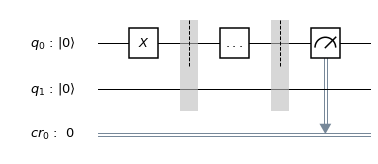

In [82]:
# draw the second circuit
tmp_qr = q.QuantumRegister(2, 'q')
tmp_cr = q.ClassicalRegister(1, 'cr')
tmp_qc = q.QuantumCircuit(tmp_qr, tmp_cr)
tmp_qc.x(tmp_qr[0])
tmp_qc.barrier()
tmp_qc.iden(tmp_qr[0])
tmp_qc.barrier()
tmp_qc.measure(tmp_qr[0], tmp_cr[0])
tmp_qc.draw(output='mpl', style=style)

![bad measure](img/t1_bad.png)

This means that we cannot measure multiple qubits at once, which is a little bad for experimental conditions. However, it appears that there is a way to specify the physical qubit mappings separately using the `initial_layout` dictionary argument to `qiskit.execute`.

Using initial layout `qr 0 -> q 0` on the `ibmqx2` (job ID `5cc35f9cc25c4c007332e2ac`), I get the exponential model: `0.7825689539399087 0.002577397595447443 0.07776446818269347`:

![qubit 0 measurement](img/t1_q0.png)

On the other hand, using initial layout `qr 0 -> q 1` on `ibmqx2` (job ID `5cc3614bb2f4f00071ae3f71`), I get the model: `0.8301479690560788 0.002653525919427273 0.05802304155692676`:

![qubit 1 measurement](img/t1_q1.png)

At the time of writing (and running) the latest advertised calibration values for qubits 0 and 1 on the Yorktown machine are 87.5 and 60.0 microseconds. This is a 0.686 relative difference, which is not close to the 0.971 that we got from the experiment. I wonder if we're overfitting the model; i.e. the model should look something like $e^{-bt}$ instead of $ae^{-bt} + c$. Using an adjusted model $e^{-bt + c}$, or equivalently $ae^{-bt}$ (where the $c$ accounts for some delay before the energy relaxation kicks in), I get a ratio of 0.866, which is better but still rather far off. If I have a pure exponential model with no coefficients/constants, I get 0.934.

I'm rambling at this point, but I'd like to note for my own future reference that [O'Malley](https://web.physics.ucsb.edu/~martinisgroup/theses/OMalley2016.pdf) does indeed use the "fully parameterized" version of the exponential model. He also has what looks like a fairly thorough discussion of noise, although I haven't gone through it.